# Project work, part 3
Sara Hørte

### Links

GitHub repo link: 
https://github.com/sarahorte/ind320project.git

Streamlit app link: 
https://ind320project.streamlit.app/

### Log
I began by familiarizing myself with the Open-Meteo API (https://open-meteo.com/en/docs) to determine how to fetch the weather data I needed. I also identified the latitude and longitude coordinates for the cities representing each Norwegian price area. Using this information, I implemented a function to retrieve hourly weather data and tested it successfully on Bergen for 2019. This provided a foundation for integrating live weather data into the application instead of relying on static CSV files.

Next, I developed functions for detecting outliers and anomalies in the weather data. I implemented both SPC-based outlier detection for temperature series and Local Outlier Factor (LOF) for precipitation. While testing these functions on Bergen, I found selecting appropriate parameters challenging, as their optimal values depend on the data characteristics. Nevertheless, the functions worked as intended, providing both visualizations and summary statistics, and I designed them to allow easy parameter adjustments as I gain more experience.

Following this, I focused on time series analysis techniques. I implemented Seasonal-Trend decomposition using LOESS (STL) and a spectrogram analysis to explore patterns in Elhub electricity production data. To do this efficiently, I reused and adapted code from a previous assignment, ensuring it could handle the Elhub data structure. Choosing parameters for STL and the spectrogram proved difficult, and I realized that interpreting the spectrogram plots meaningfully requires a deeper understanding of frequency-domain patterns in production data.

Once the analysis functions were in place, I turned to integrating them into the Streamlit application. I reorganized the app structure and created skeletons for the new pages. I updated existing pages to fetch weather data directly from the API rather than static files, ensuring that the data tables and interactive plots dynamically reflected the selected price area. I then developed the new “Outlier & Anomaly” page (page B), reusing the functions from the notebook. To maintain clarity and functionality, I included the entire functions at the start of the script.

Finally, I created the “STL & Spectrogram” page (page A). Here, users can select a production group and adjust analysis parameters interactively. I ensured the data preparation accounted for duplicates by summing production values when multiple entries existed for the same timestamp. This allowed the STL and spectrogram functions to work reliably on hourly production data. Overall, the development process involved iterative testing, parameter tuning, and careful data preparation to ensure that the application provides meaningful insights into both weather and energy production patterns.

For convenience, I reused the selected price area from the Energy page across all subsequent pages, though in the future I think it might be more user-friendly to allow the user to choose a price area individually on each page.

### AI usage
AI was used extensively throughout this project, primarily through ChatGPT and GitHub Copilot in VS Code. I leveraged AI to generate code suggestions, adapt examples from lectures, and refine solutions for specific tasks. For instance, when implementing the Local Outlier Factor method, I combined code snippets from lectures with AI-generated suggestions, then iteratively adjusted and tested the code until it functioned correctly.

I also used AI to interpret error messages and propose potential fixes. By testing different solutions suggested by ChatGPT, I was able to identify the most effective approach. Additionally, AI assisted in generating initial visualizations, which I later fine-tuned to achieve the desired appearance. For parameter selection in the various analysis functions, ChatGPT provided guidance, which was helpful as a starting point, though understanding the underlying concepts is essential for making meaningful choices.

The interactive nature of the Streamlit app made it easy to experiment with different parameters, and AI guidance accelerated this process. Beyond coding, I also used ChatGPT to refine and improve the wording of both the project log and the AI usage section itself, ensuring clarity and readability.

Overall, AI proved to be a valuable tool for both code development and documentation, complementing my own understanding and enabling more efficient problem-solving.

In [1]:
# To make sure plotly plots are included correctly in nbconvert exports
import plotly.io as pio

# Temporarily set renderer for nbconvert
if "JPY_PARENT_PID" in globals():
    # Running inside Jupyter Notebook
    pio.renderers.default = "notebook_connected"  # keeps interactive plots in notebook
else:
    # For nbconvert / webpdf
    pio.renderers.default = "png"  # renders as image in PDF

### Weather data

In [2]:
# Use Oslo, Kristiansand, Trondheim, Tromsø and Bergen as representatives for the five electricity price areas in Norway. 
import pandas as pd

# Define representative cities for each price area
price_area_data = [
    {"price_area": "NO1", "city": "Oslo", "latitude": 59.9127, "longitude": 10.7461},
    {"price_area": "NO2", "city": "Kristiansand", "latitude": 58.1467, "longitude": 7.9956},
    {"price_area": "NO3", "city": "Trondheim", "latitude": 63.4305, "longitude": 10.3951},
    {"price_area": "NO4", "city": "Tromsø", "latitude": 69.6489, "longitude": 18.9551},
    {"price_area": "NO5", "city": "Bergen", "latitude": 60.393, "longitude": 5.3242},
]

# Create DataFrame
df_price_areas = pd.DataFrame(price_area_data)

# Display
print(df_price_areas)

  price_area          city  latitude  longitude
0        NO1          Oslo   59.9127    10.7461
1        NO2  Kristiansand   58.1467     7.9956
2        NO3     Trondheim   63.4305    10.3951
3        NO4        Tromsø   69.6489    18.9551
4        NO5        Bergen   60.3930     5.3242


In [3]:
# --- Cell: ERA5 API fetch function ---
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry

# Setup cached session (so you don't overload the API)
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)


def fetch_era5_data(lat, lon, year):
    """
    Downloads hourly ERA5 reanalysis data for a given location and year
    using Open-Meteo's historical archive API.
    """
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "hourly": [
            "temperature_2m",
            "precipitation",
            "wind_speed_10m",
            "wind_gusts_10m",
            "wind_direction_10m"
        ],
        "timezone": "Europe/Oslo",
        "wind_speed_unit": "ms",
        "models": "era5"   # explicitly request ERA5 reanalysis data
    }

    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]

    hourly = response.Hourly()
    data = {
        "time": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ),
        "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
        "precipitation": hourly.Variables(1).ValuesAsNumpy(),
        "wind_speed_10m": hourly.Variables(2).ValuesAsNumpy(),
        "wind_gusts_10m": hourly.Variables(3).ValuesAsNumpy(),
        "wind_direction_10m": hourly.Variables(4).ValuesAsNumpy(),
    }

    df = pd.DataFrame(data)
    df["time"] = pd.to_datetime(df["time"]).dt.tz_convert("Europe/Oslo")
    df.set_index("time", inplace=True)
    return df


In [4]:
# Bergen coordinates
bergen_lat, bergen_lon = 60.393, 5.3242
bergen_2019 = fetch_era5_data(bergen_lat, bergen_lon, 2019)

print(bergen_2019.head())

                           temperature_2m  precipitation  wind_speed_10m  \
time                                                                       
2019-01-01 00:00:00+01:00            6.70            0.4       11.853270   
2019-01-01 01:00:00+01:00            6.55            0.5       13.322162   
2019-01-01 02:00:00+01:00            6.80            0.9       13.505925   
2019-01-01 03:00:00+01:00            6.85            0.7       14.621901   
2019-01-01 04:00:00+01:00            6.55            0.6       15.487092   

                           wind_gusts_10m  wind_direction_10m  
time                                                           
2019-01-01 00:00:00+01:00       22.700001          260.776154  
2019-01-01 01:00:00+01:00       24.400000          277.765076  
2019-01-01 02:00:00+01:00       22.299999          296.375275  
2019-01-01 03:00:00+01:00       23.700001          310.006195  
2019-01-01 04:00:00+01:00       27.400000          314.215271  


## Outliers and anomalies

### Plotting temperature

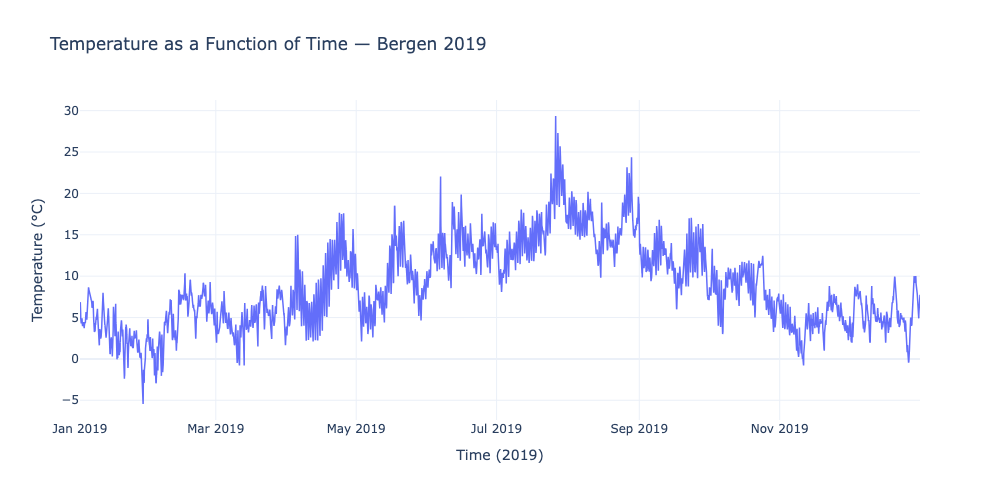

In [5]:
import plotly.graph_objects as go

# Extract temperature data
temp_series = bergen_2019["temperature_2m"]

# Create interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=temp_series.index,
    y=temp_series.values,
    mode='lines',
    name='Temperature (°C)',
    line=dict(width=1.5)
))

fig.update_layout(
    title='Temperature as a Function of Time — Bergen 2019',
    xaxis_title='Time (2019)',
    yaxis_title='Temperature (°C)',
    hovermode='x unified',
    template='plotly_white',
    height=500,
    width=1000
)

fig.show()


In [6]:
# --- Cell: SPC outlier detection (DCT SATV) + Plotly plotting ---
import numpy as np
import pandas as pd
from scipy.fftpack import dct, idct
import plotly.graph_objects as go

# DCT-based seasonal decomposition and SATV calculation
def dct_seasonal_and_satv(series: pd.Series, cutoff_frac: float = 0.05):
    """Return seasonal component (low-frequency DCT reconstruction) and SATV = series - seasonal."""
    x = series.values.astype(float)
    n = len(x)
    X = dct(x, norm='ortho')
    keep = int(np.floor(cutoff_frac * n))
    if keep < 1:
        keep = 1
    seasonal_coeffs = np.zeros_like(X)
    seasonal_coeffs[:keep] = X[:keep]
    seasonal = idct(seasonal_coeffs, norm='ortho')
    satv = x - seasonal
    return pd.Series(seasonal, index=series.index), pd.Series(satv, index=series.index)

# Median Absolute Deviation
def mad(arr):
    med = np.median(arr)
    return np.median(np.abs(arr - med))

# SPC outlier detection and Plotly plotting function
def spc_outlier_plotly(temp_series: pd.Series, cutoff_frac: float = 0.05, k: float = 3.0, title: str = None):
    """
    temp_series: pandas Series with datetime index and temperature values (°C).
    cutoff_frac: fraction of lowest DCT frequencies to KEEP as seasonal (default 0.05; 0.04–0.08 are sensible range).
    k: number of robust standard deviations to use for SPC boundaries (default 3).
    Returns: (plotly_fig, summary_dict)
    """
    if not isinstance(temp_series.index, pd.DatetimeIndex):
        temp_series = temp_series.copy()
        temp_series.index = pd.to_datetime(temp_series.index)

    temp_series = temp_series.sort_index()
    seasonal, satv = dct_seasonal_and_satv(temp_series, cutoff_frac=cutoff_frac)

    # robust stats on SATV
    med = float(np.median(satv.values))
    mad_val = float(mad(satv.values))
    sigma = float(1.4826 * mad_val) if mad_val > 0 else float(np.std(satv.values))

    # SATV thresholds (constant values) and convert to original scale by adding seasonal component
    lower_satv = med - k * sigma
    upper_satv = med + k * sigma
    lower_curve = seasonal + lower_satv
    upper_curve = seasonal + upper_satv

    outlier_mask = (satv < lower_satv) | (satv > upper_satv)
    n_points = len(temp_series)
    n_outliers = int(outlier_mask.sum())
    outlier_fraction = n_outliers / n_points if n_points > 0 else 0.0

    # Build Plotly figure
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=temp_series.index, y=temp_series.values, mode='lines', name='Temperature'))
    fig.add_trace(go.Scatter(x=temp_series.index, y=upper_curve.values, mode='lines', name=f'Upper SPC (k={k})', line=dict(dash='dash')))
    fig.add_trace(go.Scatter(x=temp_series.index, y=lower_curve.values, mode='lines', name=f'Lower SPC (k={k})', line=dict(dash='dash')))
    if n_outliers > 0:
        fig.add_trace(go.Scatter(x=temp_series.index[outlier_mask], y=temp_series.values[outlier_mask],
                                 mode='markers', name='Outliers', marker=dict(size=6, symbol='x')))

    fig.update_layout(
        title=title or 'Temperature and SPC outliers (DCT-based SATV)',
        xaxis_title='Time',
        yaxis_title='Temperature (°C)',
        hovermode='x unified',
        template='plotly_white',
        height=520,
        width=1100
    )

    summary = {
        'n_points': n_points, # total number of data points
        'n_outliers': n_outliers, # number of detected outliers
        'outlier_fraction': outlier_fraction, # fraction of outliers
        'median_satv': med, # median of SATV
        'mad_satv': mad_val, # MAD of SATV
        'sigma_est': sigma, # robust std dev estimate of SATV
        'cutoff_frac': float(cutoff_frac), # DCT cutoff fraction
        'k': float(k), # SPC k parameter
        'example_outlier_times': list(map(str, temp_series.index[outlier_mask][:20])) # first 20 outlier timestamps as strings
    }

    return fig, summary




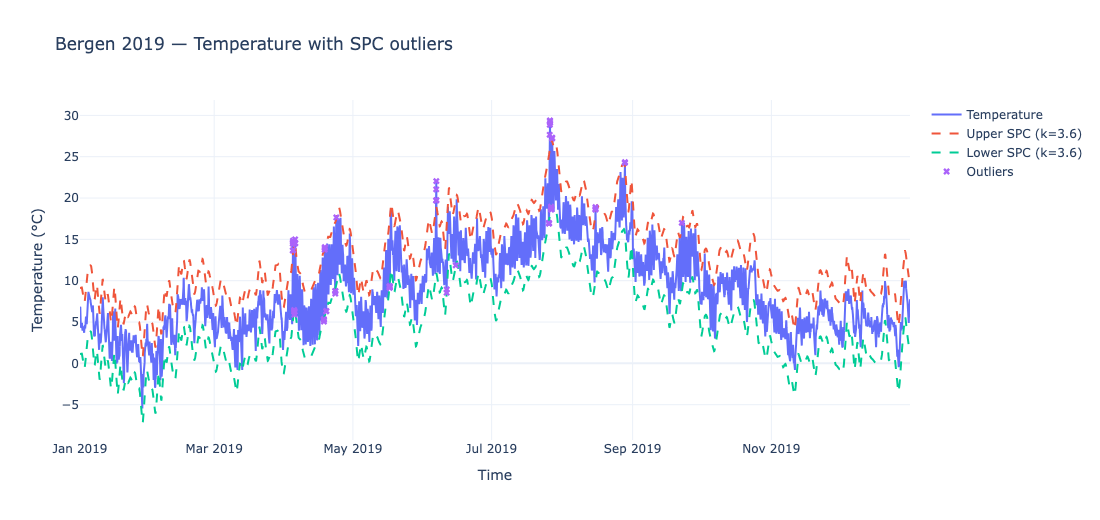

{'n_points': 8760, 'n_outliers': 57, 'outlier_fraction': 0.006506849315068493, 'median_satv': -0.04621085265696934, 'mad_satv': 0.7490424516043817, 'sigma_est': 1.1105303387486563, 'cutoff_frac': 0.04, 'k': 3.6, 'example_outlier_times': ['2019-04-04 13:00:00+02:00', '2019-04-04 14:00:00+02:00', '2019-04-04 15:00:00+02:00', '2019-04-04 16:00:00+02:00', '2019-04-04 17:00:00+02:00', '2019-04-04 18:00:00+02:00', '2019-04-05 04:00:00+02:00', '2019-04-05 05:00:00+02:00', '2019-04-05 06:00:00+02:00', '2019-04-05 07:00:00+02:00', '2019-04-05 08:00:00+02:00', '2019-04-05 13:00:00+02:00', '2019-04-05 14:00:00+02:00', '2019-04-05 15:00:00+02:00', '2019-04-18 05:00:00+02:00', '2019-04-18 06:00:00+02:00', '2019-04-18 07:00:00+02:00', '2019-04-18 14:00:00+02:00', '2019-04-18 15:00:00+02:00', '2019-04-18 16:00:00+02:00']}


In [7]:
# For Bergen 2019  temperature data. Testing the function with different parameters. Choosing cutoff_frac=0.04 and k=3.6 to get a outlier fraction around 1%.
temp_series = bergen_2019['temperature_2m']
fig, summary = spc_outlier_plotly(temp_series, cutoff_frac=0.04, k=3.6, title='Bergen 2019 — Temperature with SPC outliers')
fig.show()
print(summary)

In [8]:
# --- Experiment 1: vary k ---
cutoff_frac = 0.04
k_values = [2.5, 3.0, 3.5, 4.0]
results_k = []

for k in k_values:
    _, summary = spc_outlier_plotly(bergen_2019['temperature_2m'], cutoff_frac=cutoff_frac, k=k, title=None)
    results_k.append({'k': k, 'outlier_fraction': summary['outlier_fraction']})

df_k = pd.DataFrame(results_k)
df_k


,k,outlier_fraction
0,2.5,0.047489
1,3.0,0.021804
2,3.5,0.007991
3,4.0,0.002740


In [9]:
# --- Experiment 2: vary cutoff_frac ---
k = 3.0
cutoff_values = [0.02, 0.03, 0.04, 0.05, 0.06]
results_cutoff = []

for cf in cutoff_values:
    _, summary = spc_outlier_plotly(bergen_2019['temperature_2m'], cutoff_frac=cf, k=k, title=None)
    results_cutoff.append({'cutoff_frac': cf, 'outlier_fraction': summary['outlier_fraction']})

df_cutoff = pd.DataFrame(results_cutoff)
df_cutoff

,cutoff_frac,outlier_fraction
0,0.02,0.011986
1,0.03,0.014840
2,0.04,0.021804
3,0.05,0.027283
4,0.06,0.031164


### Plotting percipitation

In [10]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.neighbors import LocalOutlierFactor

def lof_precipitation_plotly(precip_series: pd.Series, contamination: float = 0.01, n_neighbors: int = 20, title: str = None):
    """
    Detect precipitation anomalies using the Local Outlier Factor (LOF) method and visualize with Plotly.

    Parameters
    ----------
    precip_series : pandas.Series
        Time series of precipitation (mm/hour or mm/day) with datetime index.
    contamination : float, optional
        Proportion of outliers (default 0.01 = 1%).
    n_neighbors : int, optional
        Number of neighbors to use for LOF (default 20).
    title : str, optional
        Custom plot title.

    Returns
    -------
    fig : plotly.graph_objects.Figure
        Interactive Plotly figure of precipitation with anomalies marked.
    summary : dict
        Summary with counts, proportions, and example outlier timestamps.
    """

    # Ensure datetime index
    if not isinstance(precip_series.index, pd.DatetimeIndex):
        precip_series = precip_series.copy()
        precip_series.index = pd.to_datetime(precip_series.index)
    precip_series = precip_series.sort_index()

    # Prepare data for LOF (2D input required)
    X = precip_series.values.reshape(-1, 1)

    # Fit LOF model
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    preds = lof.fit_predict(X)
    lof_scores = -lof.negative_outlier_factor_

    # Identify outliers
    outlier_mask = preds == -1
    n_points = len(precip_series)
    n_outliers = int(outlier_mask.sum())
    outlier_fraction = n_outliers / n_points if n_points > 0 else 0.0

    # Build Plotly figure
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=precip_series.index, y=precip_series.values,
        mode='lines', name='Precipitation'
    ))

    if n_outliers > 0:
        fig.add_trace(go.Scatter(
            x=precip_series.index[outlier_mask],
            y=precip_series.values[outlier_mask],
            mode='markers',
            name='Anomalies (LOF)',
            marker=dict(color='red', size=6, symbol='x')
        ))

    fig.update_layout(
        title=title or f'Precipitation anomalies (LOF, contamination={contamination*100:.1f}%)',
        xaxis_title='Time',
        yaxis_title='Precipitation',
        hovermode='x unified',
        template='plotly_white',
        height=520,
        width=1100
    )

    summary = {
        'n_points': n_points,
        'n_outliers': n_outliers,
        'outlier_fraction': outlier_fraction,
        'contamination_param': contamination,
        'n_neighbors': n_neighbors,
        'lof_score_min': float(lof_scores.min()),
        'lof_score_max': float(lof_scores.max()) # max LOF score. LOF scores indicate the degree of outlierness; higher scores mean more anomalous.
        }

    return fig, summary


/opt/anaconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning:

Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.



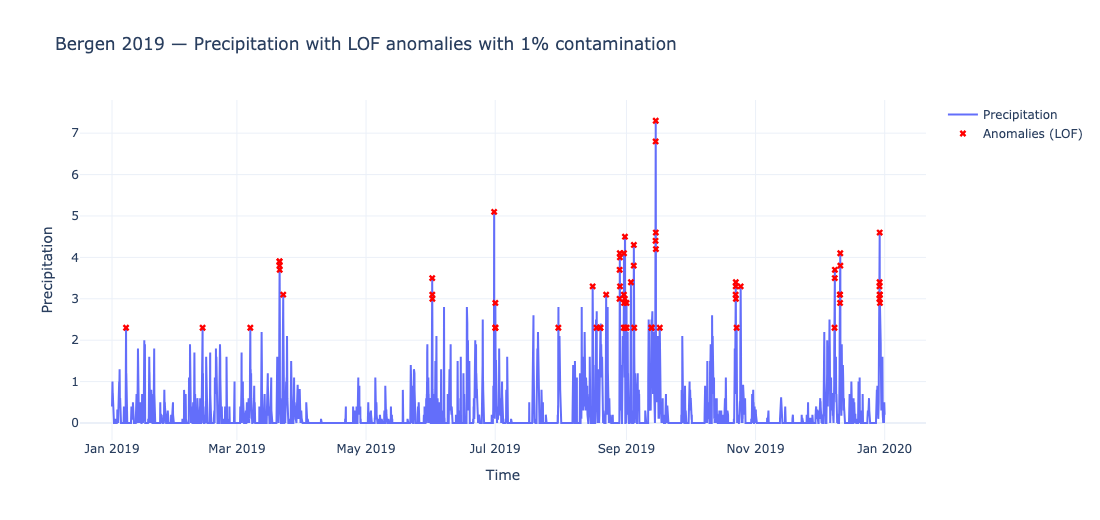

{'n_points': 8760,
 'n_outliers': 68,
 'outlier_fraction': 0.007762557077625571,
 'contamination_param': 0.01,
 'n_neighbors': 20,
 'lof_score_min': 0.9841943979263306,
 'lof_score_max': 149999856.0}

In [11]:
# Example test for Bergen 2019 precipitation data
fig_lof, summary_lof = lof_precipitation_plotly(bergen_2019["precipitation"], contamination=0.01, title='Bergen 2019 — Precipitation with LOF anomalies with 1% contamination')
fig_lof.show()
summary_lof


### Seasonal-Trend decomposition using LOESS (STL) 

In [12]:
# Copying code from part 2 of the project to fetch Elhub data

# =============================
# 1️⃣ FETCH DATA FROM ELHUB API
# =============================
import requests
import pandas as pd
from datetime import datetime, timedelta
import time

# --- API SETTINGS ---
BASE_URL = "https://api.elhub.no/energy-data/v0/price-areas"
DATASET = "PRODUCTION_PER_GROUP_MBA_HOUR"

# --- FUNCTION TO FORMAT DATES ---
def format_date(dt_obj):
    """Formats datetime with timezone offset for Elhub (%2B02:00)."""
    return dt_obj.strftime("%Y-%m-%dT%H:%M:%S%%2B02:00")  # +02:00 is used for MBA data

all_records = []

# --- FETCH MONTHLY DATA FOR 2021 ---
for month in range(1, 13):
    start = datetime(2021, month, 1)
    next_month = (start + timedelta(days=32)).replace(day=1)
    end = next_month - timedelta(seconds=1)

    start_str = format_date(start)
    end_str = format_date(end)

    url = f"{BASE_URL}?dataset={DATASET}&startDate={start_str}&endDate={end_str}"
    print(f"=== Fetching {start.date()} → {end.date()} ===")

    response = requests.get(url)
    if response.status_code != 200:
        print(f"❌ Error {response.status_code}")
        continue

    data = response.json()
    month_records = []

    for entry in data.get("data", []):
        attrs = entry.get("attributes", {})
        recs = attrs.get("productionPerGroupMbaHour", [])
        # Filter out placeholders
        recs = [r for r in recs if r.get("productionGroup") != "*"]
        month_records.extend(recs)

    all_records.extend(month_records)
    print(f"✅ {len(month_records)} records added")

    # Be kind to API
    time.sleep(1)

print(f"\nTotal records collected: {len(all_records)}")

# --- CONVERT TO DATAFRAME ---
df = pd.DataFrame(all_records)
df['startTime'] = pd.to_datetime(df['startTime'], utc=True)
df['endTime'] = pd.to_datetime(df['endTime'], utc=True)
df['quantityKwh'] = pd.to_numeric(df['quantityKwh'], errors='coerce')
df = df[['priceArea', 'productionGroup', 'startTime', 'quantityKwh']]
df.sort_values('startTime', inplace=True)
df.set_index('startTime', inplace=True)

print(df.info())
print(df.head(50))
print(f"DataFrame shape: {df.shape}")


=== Fetching 2021-01-01 → 2021-01-31 ===
✅ 17856 records added
=== Fetching 2021-02-01 → 2021-02-28 ===
✅ 16128 records added
=== Fetching 2021-03-01 → 2021-03-31 ===
✅ 17832 records added
=== Fetching 2021-04-01 → 2021-04-30 ===
✅ 17280 records added
=== Fetching 2021-05-01 → 2021-05-31 ===
✅ 17856 records added
=== Fetching 2021-06-01 → 2021-06-30 ===
✅ 17976 records added
=== Fetching 2021-07-01 → 2021-07-31 ===
✅ 18600 records added
=== Fetching 2021-08-01 → 2021-08-31 ===
✅ 18600 records added
=== Fetching 2021-09-01 → 2021-09-30 ===
✅ 18000 records added
=== Fetching 2021-10-01 → 2021-10-31 ===
✅ 18625 records added
=== Fetching 2021-11-01 → 2021-11-30 ===
✅ 18000 records added
=== Fetching 2021-12-01 → 2021-12-31 ===
✅ 18600 records added

Total records collected: 215353
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215353 entries, 2020-12-31 23:00:00+00:00 to 2021-12-31 22:00:00+00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ---

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import STL

def stl_decomposition_plotly_subplots(
    df,
    price_area='NO1',
    production_group='hydro',
    period=24,
    seasonal=13,
    trend=25,
    robust=True
):
    """
    STL decomposition with four stacked subplots (Original, Trend, Seasonal, Residual) using Plotly.

    Returns the figure and STL results object.
    """
    # Case-insensitive filtering
    ts = df[(df['priceArea'].str.lower() == price_area.lower()) &
            (df['productionGroup'].str.lower() == production_group.lower())]['quantityKwh']
    
    if ts.empty:
        raise ValueError(f"No data found for price area '{price_area}' and production group '{production_group}'")
    
    # Fill missing values
    ts = ts.asfreq('h').ffill()
    
    # Fit STL
    stl = STL(ts, period=period, seasonal=seasonal, trend=trend, robust=robust)
    res = stl.fit()
    
    # Create subplots
    fig = make_subplots(
        rows=4, cols=1, shared_xaxes=True,
        vertical_spacing=0.02,
        subplot_titles=['Original', 'Trend', 'Seasonal', 'Residual']
    )
    
    # Original
    fig.add_trace(go.Scatter(x=ts.index, y=ts, mode='lines', name='Original', line=dict(color='blue')), row=1, col=1)
    # Trend
    fig.add_trace(go.Scatter(x=ts.index, y=res.trend, mode='lines', name='Trend', line=dict(color='orange')), row=2, col=1)
    # Seasonal
    fig.add_trace(go.Scatter(x=ts.index, y=res.seasonal, mode='lines', name='Seasonal', line=dict(color='green')), row=3, col=1)
    # Residual
    fig.add_trace(go.Scatter(x=ts.index, y=res.resid, mode='lines', name='Residual', line=dict(color='red')), row=4, col=1)
    
    fig.update_layout(
        height=900,
        title_text=f"STL Decomposition: {production_group} in {price_area}",
        template='plotly_white'
    )
    
    fig.show()
    
    return fig, res


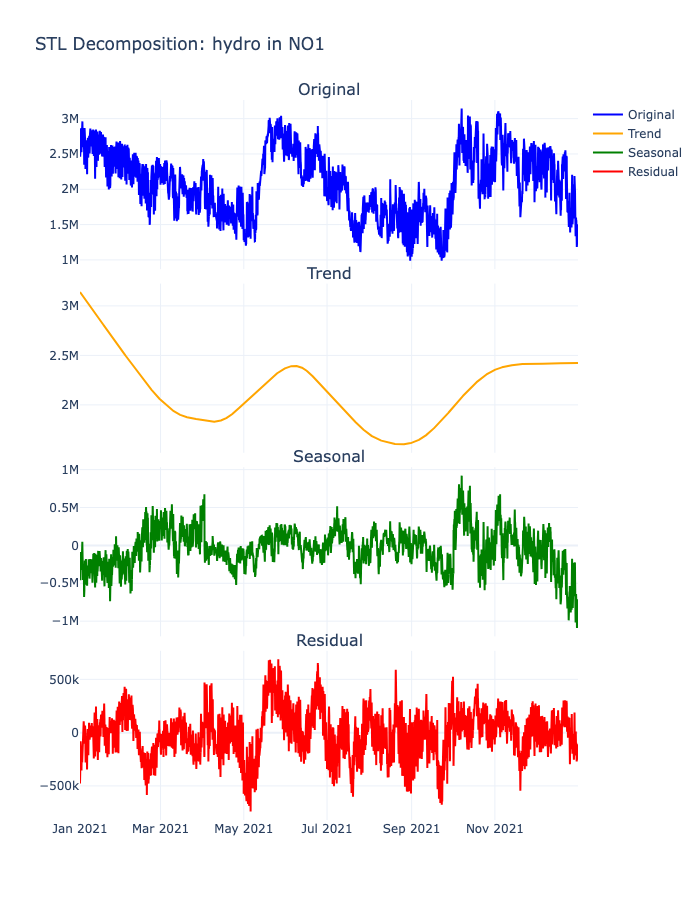

In [14]:
# Using large parameters tp se the long-term seasonality in hydro production
fig, res = stl_decomposition_plotly_subplots(
    df,
    price_area='NO1',
    production_group='hydro',
    period= 2190,
    seasonal=2191,
    trend=2191,
    robust=False
)


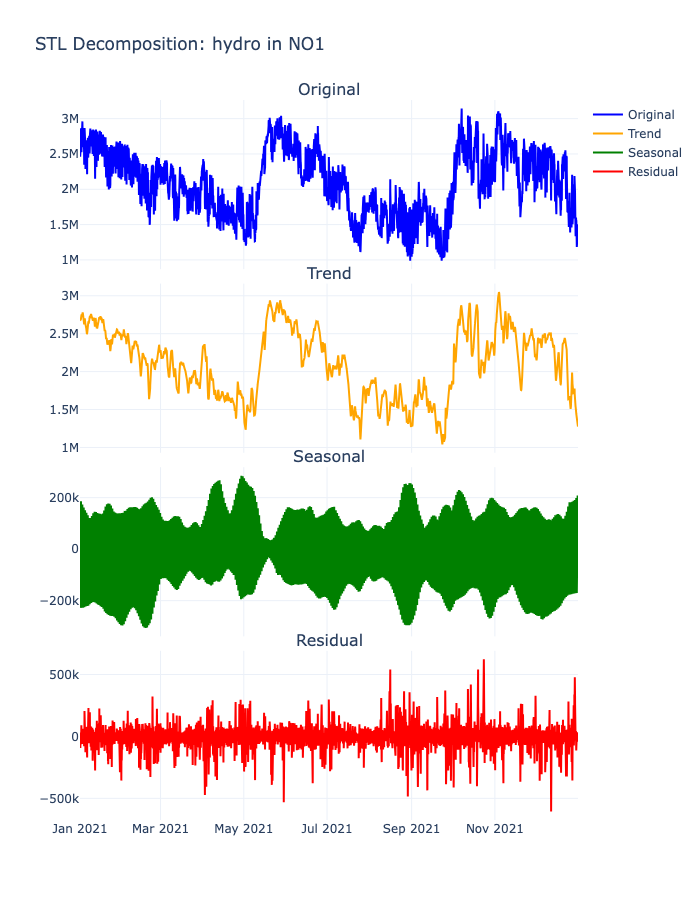

In [15]:
# Using other parameters. Suggestion from chatGPT
fig, res = stl_decomposition_plotly_subplots(
    df,
    price_area='NO1',
    production_group='hydro',
    period=24,     # daily seasonality
    seasonal=13,   # smooth daily pattern
    trend=25,      # slow trend over the year
    robust=True
)


### Spectrogram 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

def matplotlib_spectrogram(
    df,
    price_area='NO1',
    production_group='hydro',
    window_length=168,   # nperseg in STFT
    window_overlap=84,   # noverlap in STFT
    fs=1                 # sampling frequency (1 per hour)
):
    """
    Compute and plot a spectrogram for electricity production data using Matplotlib.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with ['priceArea','productionGroup','quantityKwh'] indexed by datetime.
    price_area : str
        Electricity price area to filter.
    production_group : str
        Production group to filter.
    window_length : int
        Number of samples per STFT window (nperseg).
    window_overlap : int
        Overlap between windows (noverlap).
    fs : float
        Sampling frequency. For hourly data, fs=1.

    Returns
    -------
    f : np.ndarray
        Frequency bins.
    t : np.ndarray
        Time bins.
    Zxx : np.ndarray
        STFT complex values.
    """
    # Filter data
    ts = df[(df['priceArea'].str.lower() == price_area.lower()) &
            (df['productionGroup'].str.lower() == production_group.lower())]['quantityKwh']
    
    if ts.empty:
        raise ValueError(f"No data for price area '{price_area}' and production group '{production_group}'")
    
    ts = ts.asfreq('h').ffill()
    
    # Compute STFT
    f, t, Zxx = stft(ts.values, fs=fs, nperseg=window_length, noverlap=window_overlap)
    
    # Plot with Matplotlib
    plt.figure(figsize=(12, 5))
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='viridis', vmin=0, vmax=np.max(np.abs(Zxx)))
    plt.title(f'Spectrogram: {production_group} in {price_area}')
    plt.ylabel('Frequency [1/hour]')
    plt.xlabel('Time [hours]')
    plt.colorbar(label='Amplitude')
    plt.tight_layout()
    plt.show()
    
    return f, t, Zxx


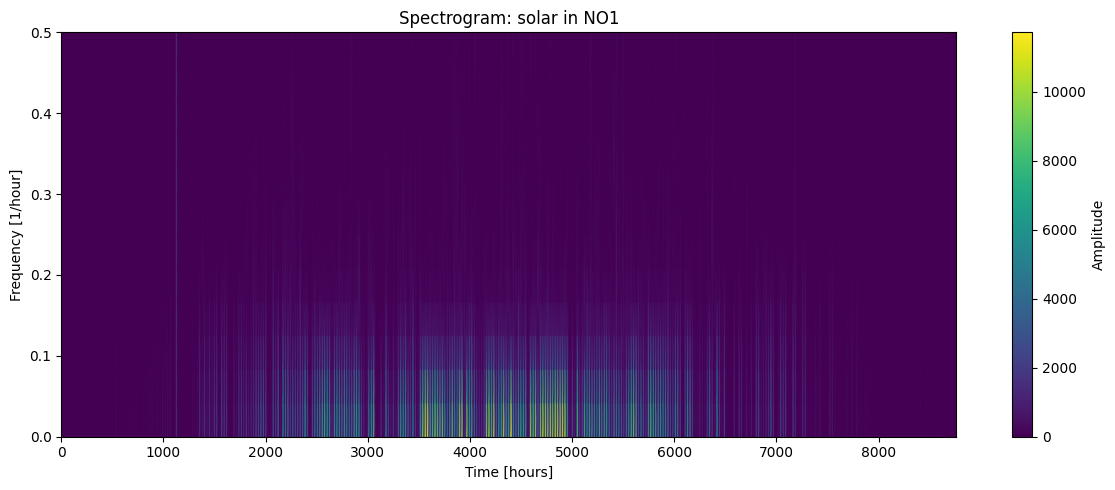

In [17]:
# Testing the spectrogram function with solar production data
f, t, Zxx = matplotlib_spectrogram(
    df,
    price_area='NO1',
    production_group='solar',
    window_length=24,   # 1 day of hourly data
    window_overlap=12,   # 50% overlap
    fs=1
)